# Text Mining Coursework 2
## Topic: WinterOlympics
Team members: 
Bushui Zhang (UID: 10407579), Yazhuo Cao (UID: 10329221), Yecheng Chu (UID: 10319044), Zhaoyu Zhang (UID:10838545), Zhengqian Jin (UID:10839527)
### 3 Questions: 
1) What were the most talked about topics for the Winter Olympics?

2) What is the dominant sentiment towards the Winter Olympics?

3) Which 2 countries have been mostly talked about during Winter Olympics? What do people think of them?

## Libraries Used

In [1]:
# may need to download a few packages
# !pip install tweepy==4.8.0
# !pip install emoji
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

# ignore warnings for now
warnings.filterwarnings("ignore")

C:\Users\ZhaYu517\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_md' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Access Tokens

In [ ]:
api_token = "jXMA8AEL8KW4QBQpJZw69Mh77"
api_token_secret = "uD6xTzrqVU26M0MS7lG9s81FRgHUu5gHzDBhPp9Nf3goFObe19"
access_token = "1324002361694654465-8LZDKWBXdb6ac1J30r6SsRrfJj5Fh1"
access_token_secret = "PQKX7cInfMhrGi9mL63PlABxhdQlzXEMY1URBzQMxxiOk"
bearer_token = "AAAAAAAAAAAAAAAAAAAAADBgaQEAAAAAdpWH1Wc%2BG32Sj%2FZzrKX4U3jhkCI%3D7yHS67VXIxTOj1Db5lJB1yg6AB9i1FWeS0owPW0ZjofBsJ5lGd"

tokens = {}
tokens['api_token'] = api_token
tokens['api_token_secret'] = api_token_secret
tokens['access_token'] = access_token
tokens['access_token_secret'] = access_token_secret
tokens['bearer_token'] = bearer_token

# Configuring Twitter API

In [2]:
# auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20 lang:en" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [3]:
tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])
# print(tweet_urls)

## Convert urls to tweets

In [4]:
# Extract the tweet id
tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]
# Store tweet id in another column
tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
ids = tweet_urls['tweet_ids'].tolist()

def url2tweet(IDs): # a list of ids, max 100
    all_status = api.lookup_statuses(IDs)
    tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
    return tweets_list


def get_all_tweets(IDs): # a list of ids
    num_sections = (len(IDs) - 1) // 100 + 1
    first_section = ids[:100]
    data = url2tweet(first_section)
    for i in tqdm(range(1, num_sections)):
        current_ids = ids[i*100:(i+1)*100]
        current_tweet_list = url2tweet(current_ids)
        data = np.concatenate([data, current_tweet_list])
    return data

data = get_all_tweets(ids)

  0%|          | 0/523 [00:00<?, ?it/s]

In [5]:
tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
tweets_df.head(len(tweets_df))

,date,user,location,text
0,2022-02-19 23:45:01+00:00,NEWS CENTER Maine,"Maine, USA",Tonight at 7:30: Our final Olympic Zone show o...
1,2022-02-19 23:47:19+00:00,Nicoya,Lincolnshire,"#WinterOlympics Up early for #menscurling , af..."
2,2022-02-19 23:12:02+00:00,Sweepers Curling 🥌,Edinburgh,@Team_Muirhead @richardosman Honestly! 2 hours...
3,2022-02-19 23:55:43+00:00,Georgie Heath,"London, England",To sleep and set curling alarm or just stay up...
4,2022-02-19 23:04:20+00:00,Sports update.,World,#WinterOlympics: Sweden beat Switzerland to wi...
...,...,...,...,...
52261,2022-02-04 00:00:13+00:00,NBC Connecticut,Connecticut,Cecily from Wallingford is ready to cheer on @...
52262,2022-02-04 00:04:17+00:00,UofSC College of HRSM,"Columbia, South Carolina",Sport and Entertainment Management Professor M...
52263,2022-02-04 00:00:02+00:00,Global Times,"Beijing, China",#GTGraphic: Welcome to China! When the #Beijin...
52264,2022-02-04 00:28:52+00:00,BetRivers,AZ/CO/IA/IL/IN/LA/MI/NY/PA/VA,🥌 TONIGHT 🥌\n\nanyone have some mixed curling ...


# Data Cleaning

In [6]:
def remove_emoji(string):
    string = emoji.get_emoji_regexp().sub(u'', string)
    return string

# emojis = '(｀ヘ´) 🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩🥌🍒💚🏅'
# print(remove_emoji(emojis))

In [7]:
def data_cleaning(data):
    # Remove hyperlinks
    data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

    # Remove punctuation
    data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

    # Remove unnecessary line breaks
    data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

    # Convert the titles to lowercase
    data.text = data.text.map(lambda x: x.lower())

    # Remove emojis
    data.text = data.text.map(lambda x: remove_emoji(x))

In [8]:
# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

data_cleaning(tweets_df)

# store the processed tweets to csv
tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 1: What were people mostly talked about for the Winter Olympics?

## Exploration using a word cloud

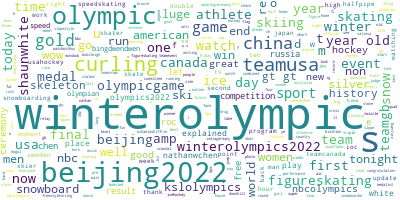

In [9]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets_all = list(set(list(tweets_df['text'].values)))
unique_tweets_all = [t for t in unique_tweets_all if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets_all)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [10]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'winterolympic', 'olympic', 'winterolympics',
                   'olympics', 'beijing','winterparalympic', 'beijing2022', 'winter', 'today', 'like', 
                   'would', 'watch', 'tonight', 'first', 'time', 'go', 'next', 'events', 'let', 
                   'love', 'year', 'watching', 'day', 'run', 'big', 'live', 'know', 'well','going', 'great'
                   , 'get', 'one', 'good', 'th', 'white', 'back','game', 'amp', 'end', 'see', 'watchwithus'
                   , 'much'])

# print(stop_words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

## Get the Mostly Talked Topics

In [11]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.010*"curling" + 0.010*"china" + 0.007*"figureskating" + 0.007*"team" + '
  '0.006*"skating" + 0.006*"final" + 0.005*"men" + 0.005*"nathan" + '
  '0.005*"teamusa" + 0.005*"chen"'),
 (1,
  '0.013*"gold" + 0.011*"curling" + 0.010*"women" + 0.009*"skating" + '
  '0.009*"men" + 0.007*"ice" + 0.006*"figure" + 0.006*"medal" + 0.005*"china" '
  '+ 0.005*"halfpipe"'),
 (2,
  '0.008*"gold" + 0.008*"team" + 0.008*"medal" + 0.007*"men" + 0.007*"teamusa" '
  '+ 0.006*"ice" + 0.005*"skiing" + 0.005*"opening" + 0.005*"coverage" + '
  '0.005*"hockey"'),
 (3,
  '0.020*"teamusa" + 0.018*"gold" + 0.014*"team" + 0.014*"curling" + '
  '0.012*"medal" + 0.009*"women" + 0.009*"usa" + 0.005*"athletes" + '
  '0.005*"win" + 0.005*"skating"'),
 (4,
  '0.012*"curling" + 0.010*"gold" + 0.008*"medal" + 0.006*"teamusa" + '
  '0.006*"women" + 0.006*"team" + 0.005*"figureskating" + 0.005*"sport" + '
  '0.005*"skating" + 0.004*"figure"')]


### Visualise the topics

In [12]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.005290  0.001099       1        1  24.329148
3      0.026145  0.035376       2        1  22.806763
0     -0.057380 -0.047370       3        1  18.612219
2      0.060782 -0.039663       4        1  17.462340
4     -0.024257  0.050558       5        1  16.789529, topic_info=         Term         Freq        Total Category  logprob  loglift
112   teamusa  3237.000000  3237.000000  Default  30.0000  30.0000
51      china  1656.000000  1656.000000  Default  29.0000  29.0000
131       men  1978.000000  1978.000000  Default  28.0000  28.0000
105  coverage   592.000000   592.000000  Default  27.0000  27.0000
55       gold  4246.000000  4246.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
252        us   180.709124  1009.646613   Topic5  -5.8660   0.0639
128       ice   207.568873  1692.160169   Topic5  -5.7274  -0.3139
127    hockey   182.110402  1283.568956   Topic5  -5.8582  -0.1684
51      china   174.250280  1656.154669   Topic5  -5.9023  -0.4673
2       final   158.760544  1433.524829   Topic5  -5.9954  -0.4161

[474 rows x 6 columns], token_table=      Topic      Freq Term
term                      
342       1  0.233276  air
342       2  0.182733  air
342       3  0.301314  air
342       4  0.141909  air
342       5  0.139965  air
...     ...       ...  ...
459       1  0.543618  yet
459       2  0.071529  yet
459       3  0.071529  yet
459       4  0.090603  yet
459       5  0.219355  yet

[1142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])

## Hence, from the visualisation above we can conclude, people were mostly talked about these topics for the Winter Olympics:
$ Gold medal $, $curling$, $skating$, $china$, $woman$ and $teamUSA$

# Task 2: What is the dominant sentiment towards the Winter Olympics?

## Sentiment Analysis

In [13]:
all_pos = 0
all_neg = 0
all_neu = 0
all_compounds = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos += 1
        elif compound_score <= -0.05:
            all_neg += 1
        else:
            all_neu += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds.append(general_compound_score)

## Visualise the result

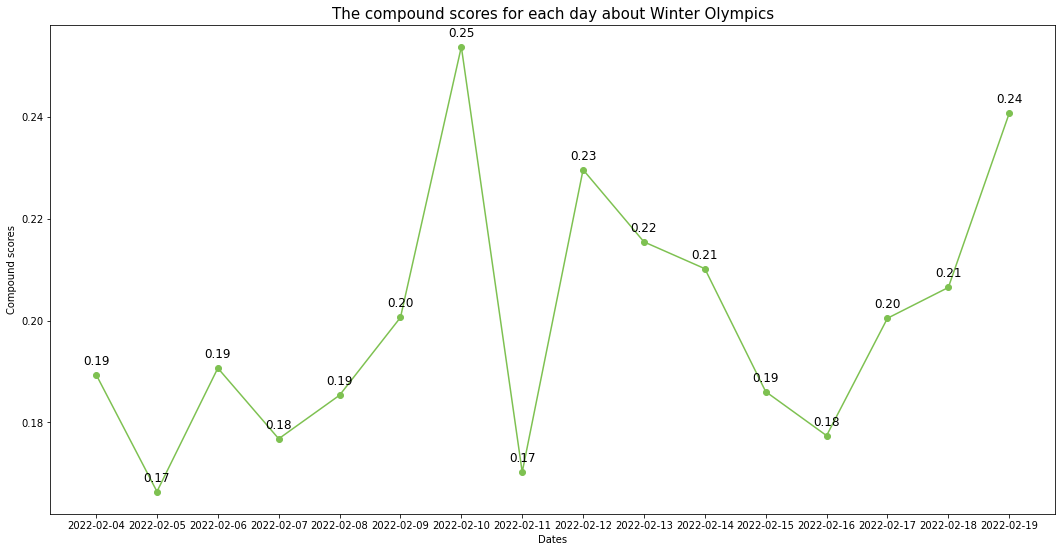

In [15]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds, 'o-', color = '#7EC151')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
plt.title("The compound scores for each day about Winter Olympics", fontsize=15)
x = dates
y = np.array(all_compounds)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.0015, '%.2f'%_y, ha='center', va='bottom', size=12, c='black')
plt.show()

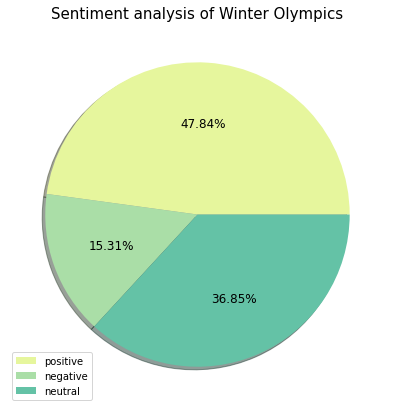

In [16]:
plt.figure(figsize=(7,7))
senti_data = [all_pos, all_neg, all_neu]
labels = ['positive', 'negative', 'neutral']
colours = ['#E6F69D','#AADEA7','#64C2A6']
plt.pie(senti_data,autopct='%1.2f%%',textprops={'fontsize': 12}, colors=colours,shadow=True)
plt.title('Sentiment analysis of Winter Olympics', fontsize=15)
plt.legend(labels)
plt.show()

# Task 3: Which 2 countries have been mostly talked about during Winter Olympics? What do people think of them?

## Named Entity Recognition

In [17]:
nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

## <span style="color:red">Uncomment the code in the cell below to do named entity recognision.As the amount of unique tweets is huge, it may take more than __one hour__ to run. For convenient, we have save the dictionary.</span>

In [29]:
countries = {}
stop_words = ['beijing2022', 'beijing']
for tweet_text in tqdm(unique_tweets_all):
    doc = nlp(tweet_text)
    for ne in doc.ents:
        if ne.label_ == 'GPE':
            tweet = tweet_text[ne.start_char:ne.end_char]
            if tweet not in stop_words and tweet not in countries.keys():
                countries[tweet] = 1
            elif tweet not in stop_words:
                countries[tweet] += 1

  0%|          | 0/50012 [00:00<?, ?it/s]

In [30]:
with open('countries.pkl', 'wb') as f:
    pickle.dump(countries, f)
        
with open('countries.pkl', 'rb') as f:
    countries = pickle.load(f)

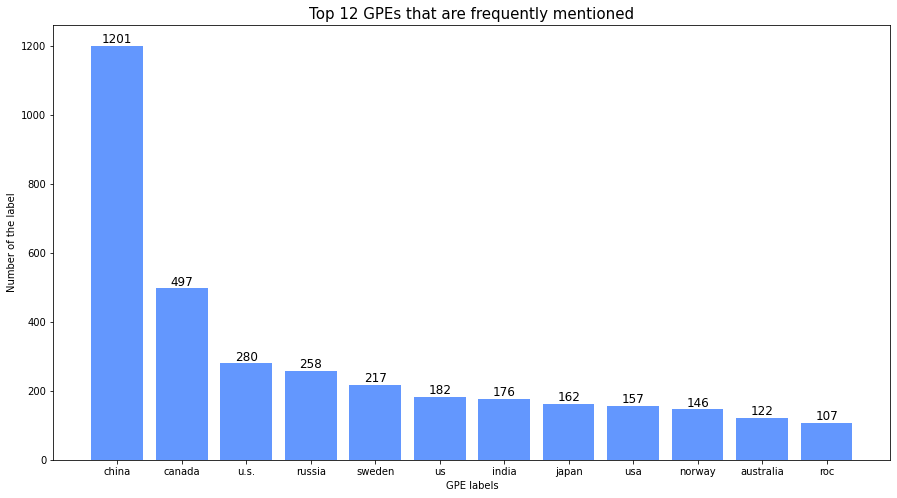

In [31]:
countries = {k: v for k, v in sorted(countries.items(), key=lambda item: item[1], reverse=True)}
names = list(countries.keys())[0:12]
values = list(countries.values())[0:12]
plt.figure(figsize=(15,8))
plt.ylabel('Number of the label')
plt.xlabel('GPE labels')
plt.title('Top 12 GPEs that are frequently mentioned', fontsize=15)

plt.bar(range(12), values, tick_label=names, color = '#6397FE')
for _x, _y in zip(np.arange(12), values):
    plt.text(_x, _y, _y, ha='center', va='bottom', size=12, c='black')
plt.show()

In [32]:
mostly_talked_country = list(countries.keys())[0]
second_talked_country = list(countries.keys())[1]
print("As the bar chart shows, the 2 mostly talked countries are " + mostly_talked_country + " and " + second_talked_country)

As the bar chart shows, the 2 mostly talked countries are china and canada


In [33]:
all_pos_m = 0
all_neg_m = 0
all_neu_m = 0
all_compounds_m = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(mostly_talked_country)]
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos_m += 1
        elif compound_score <= -0.05:
            all_neg_m += 1
        else:
            all_neu_m += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds_m.append(general_compound_score)

In [34]:
all_pos_s = 0
all_neg_s = 0
all_neu_s = 0
all_compounds_s = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(second_talked_country)]
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos_s += 1
        elif compound_score <= -0.05:
            all_neg_s += 1
        else:
            all_neu_s += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds_s.append(general_compound_score)

## Visualise the result

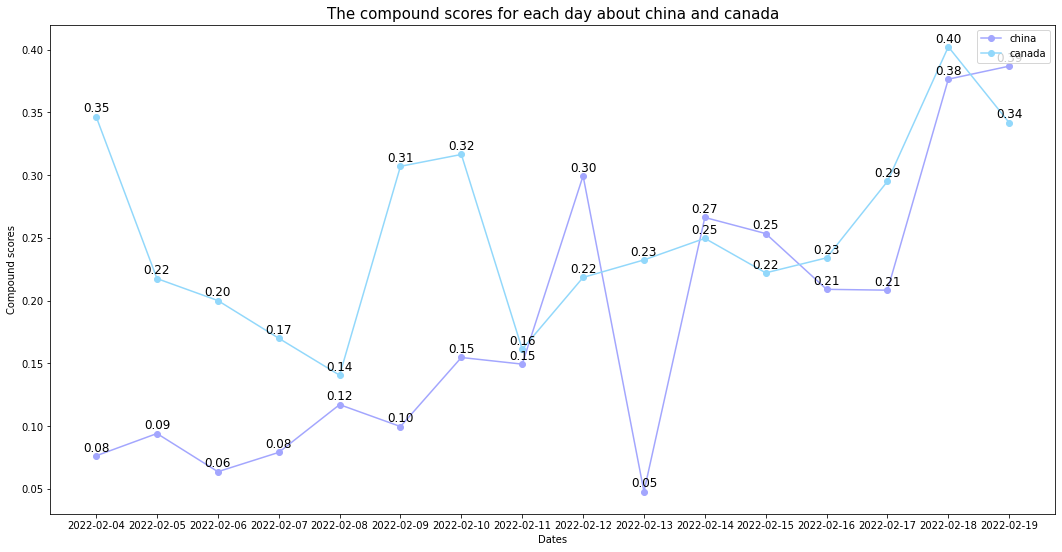

In [35]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds_m, 'o-', color = '#A3A6FE', label = mostly_talked_country)
plt.plot(all_compounds_s, 'o-', color = '#92D8FB', label = second_talked_country)
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
title_plt = "The compound scores for each day about " + mostly_talked_country + " and " + second_talked_country
plt.legend()
plt.title(title_plt, fontsize=15)
x = dates
y1 = np.array(all_compounds_m)
y2 = np.array(all_compounds_s)
for _x, _y1, _y2 in zip(x, y1, y2):
    plt.text(_x-4, _y1+0.0015, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x-4, _y2+0.0015, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.show()

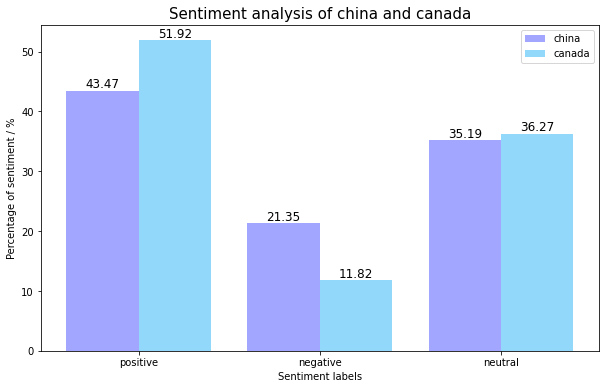

In [36]:
all_m = all_pos_m + all_neg_m + all_neu_m
all_s = all_pos_s + all_neg_s + all_neu_s
all_pos_pm = (all_pos_m / all_m) * 100
all_neg_pm = (all_neg_m / all_m) * 100
all_neu_pm = (all_neu_m / all_m) * 100
all_pos_ps = (all_pos_s / all_s) * 100
all_neg_ps = (all_neg_s / all_s) * 100
all_neu_ps = (all_neu_s / all_s) * 100
all_pm = [all_pos_pm, all_neg_pm, all_neu_pm]
all_ps = [all_pos_ps, all_neg_ps, all_neu_ps]
names = ['positive', 'negative', 'neutral']
plt.figure(figsize=(10,6))
plt.ylabel('Percentage of sentiment / %')
plt.xlabel('Sentiment labels')
title_plt = "Sentiment analysis of " + mostly_talked_country + " and " + second_talked_country
plt.title(title_plt, fontsize=15)

X_axis = np.arange(3)
plt.xticks(X_axis, names)
plt.bar(X_axis - 0.2, all_pm,0.4,label=mostly_talked_country, color = '#A3A6FE')
plt.bar(X_axis + 0.2, all_ps,0.4,label=second_talked_country, color = '#92D8FB')
for _x, _y1, _y2 in zip(np.arange(3), all_pm, all_ps):
    plt.text(_x-0.2, _y1, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x+0.2, _y2, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.legend()